In [1]:
%env CUDA_VISIBLE_DEVICES=3
import os

import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from utils.pipeline import forward, get_latent_from_text

torch.cuda.empty_cache()
device = "cuda"

env: CUDA_VISIBLE_DEVICES=3


/home/schmid/miniconda3/envs/MonoNPHM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ANCHORS HAVE SHAPE:  torch.Size([1, 1, 65, 3])
creating DeepSDF with...
lat dim 116
hidden_dim 400
Creating DeepSDF with input dim f119, hidden_dim f400 and output_dim 5
Loaded checkpoint from: /home/schmid/Text2Head/MonoNPHM/new_weights_mono//checkpoints/checkpoint_epoch_2500.tar
ANCHORS HAVE SHAPE:  torch.Size([1, 1, 65, 3])


/tmp/ipykernel_1621665/1459599460.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "camera_angle_rho": torch.tensor(angle, dtype=torch.float32),
/home/schmid/Text2Head/utils/render.py:170: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle_radians_rho = torch.deg2rad_(torch.tensor(camera_params["camera_angle_rho"]))
/home/schmid/Text2Head/utils/render.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angle_radians_theta = torch.deg2rad_(torch.tensor(camera_params["camera_angle_theta"]))
/home/schmid/miniconda3/envs/MonoNPHM/lib/p

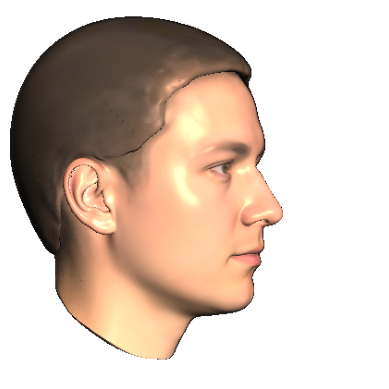

In [6]:
lat_rep = torch.load('lat_rep_0_100_1.pt')
lat_rep = [tensor.to(device) for tensor in lat_rep]
torch.cuda.empty_cache()
light_params = {
        "amb_light_color": torch.tensor([0.65, 0.66, 0.69]),
        # light 1
        "light_intensity_1": 1.69,
        "light_color_1": torch.tensor([1., 0.91, 0.88]),
        "light_dir_1": torch.tensor([0., -0.18, -0.8]),#torch.tensor([-0.85, -0.18, -0.8]),
        # light p
        "light_intensity_p": 0.52,
        "light_color_p": torch.tensor([1., 0.91, 0.88]),
        "light_pos_p": torch.tensor([0.17, 2.77, -2.25])
    }
phong_params = {
        "ambient_coeff": 0.32,
        "diffuse_coeff": 0.85,
        "specular_coeff": 0.34,
        "shininess": 25,
        # Colors
        "object_color": torch.tensor([0.53, 0.24, 0.64]),
        "background_color": torch.tensor([1., 1., 1.])
    }

prompt = "untextured render of a face"
images = []
with torch.no_grad():
    for angle in torch.arange(70, -70, -1.5):
        camera_params = {
            "camera_distance": 0.21 * 2.57,
            "camera_angle_rho": torch.tensor(angle, dtype=torch.float32),
            "camera_angle_theta": torch.tensor(0, dtype=torch.float32),
            "focal_length": 2.57,
            "max_ray_length": 3,
            # Image
            "resolution_y": 400,
            "resolution_x": 400
        }
        a = 0.85*2/140
        b = -a * (angle+70) + 0.85
        light_params['light_dir_1'] = torch.tensor([b, -0.18, -0.8])
        _, _, _, _, image = forward(lat_rep, prompt, camera_params, phong_params, light_params, with_app_grad=False, color=True)
        images.append(image)

save_dir = '../optim_img/'
os.makedirs(save_dir, exist_ok=True)
for i, im in enumerate(images):
    plt.imshow(im.detach().numpy())
    plt.axis('off')  # Turn off axes
    #plt.show()
    plt.savefig(save_dir + f"image_{i}.png", bbox_inches='tight')